# AER for HFIR Cycle 502

***
## Basic constants and functions
***

In [1]:
import numpy as np
import sympy as sym
import scipy as sc
import matplotlib.pyplot as plt
import mcstasscript as ms
import scienceplots
import time, math
from scipy.optimize import curve_fit
from scipy.signal import hilbert,convolve
from scipy.fft import fft,ifft
from scipy.integrate import quad,simpson
from matplotlib.animation import FuncAnimation, PillowWriter

plt.style.use(['science', 'notebook', 'grid', 'default', 'bright'])
plot_height = 8
plot_width = plot_height*1.618

SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 20,30,40
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)
plt.rcParams.update({'axes.grid':True})

if False: #Additions to latex preamble for matplotlib:
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsthm,amssymb,amsfonts,braket,siunitx}')
    plt.rcParams["font.family"] = "Computer Modern Roman"
sym.init_printing()

xp = 1/np.sqrt(2)*np.array([[1],[1]]) #spin states
xm = 1/np.sqrt(2)*np.array([[1],[-1]])
yp = 1/np.sqrt(2)*np.array([[1],[1j]])
ym = 1/np.sqrt(2)*np.array([[1],[-1j]])
zp = np.array([[1],[0]])
zm = np.array([[0],[1]])

sx = np.array([[0,1],[1,0]]) #Pauli operators
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])

G = -1.832471e8    #gyromagnetic ratio of neutron (rad/T/m^2)
M = 1.674927e-27    #mass of neutron (kg)
HBAR = 1.054571e-34    #plancks constant (kg m^2/s)
CL = G/(HBAR*2*np.pi)*M*1e-10    #Larmor phase constant (T^-1 m^-1 AA^-1)

In [2]:
def get_SS_focus(harm,Ls,res,ml,a,L):
    """Returns SESANS magnetic field focuing condtion (T)."""
    return 2*np.pi*harm*Ls/(res/1e3)/(CL*lam*a*(L[1] - L[0]))

def cos(x,amp,freq,phase,shim):
    """Simple cosine with shim."""
    return amp*np.cos(x*freq + phase) + shim

def quad_cos(x,amp,freq,qfreq,phase,shim):
    """Cosine with quadratic frequency and shim."""
    return amp*np.cos(x*freq + x**2*qfreq + phase) + shim

def g_cos(x,amp,freq,phase,shim,mean,sigma):
    """Cosine with Gaussian envelope and shim."""
    return amp*np.exp(-(x - mean)**2/2/sigma**2)*np.cos(x*freq + phase) + shim

In [3]:
I1,I2,I3,I4,x,phi = sym.symbols('I_1,I_2,I_3,I_4,x,phi', real=True)
L1,L2,L3,L4,a,b,lam,larm,delta = sym.symbols('L_1,L_2,L_3,L_4,a,b,lambda,c_L,delta', real=True, positive=True)

A = 5e-3 #in Tesla
B = 5e-3 #in Tesla

def MWP(a,b,I,x,phi,inv=False):
    """Field integral from MWP."""
    if inv: a = -a
    return I*(a*x + b*x*phi)

def AER(L1,L2,I1,I2,focus_SS=False):
    """Field integral with option focusing conditions."""
    result = MWP(a,b,I1,x-L1*phi,phi) + MWP(a,b,I2,x-L2*phi,phi)
    if focus_SS: result = result.subs(I2,-I1)
    return result.expand().subs(L1/L2,I2/I1).collect([a,b]).simplify() 

display(AER(L1,L2,I1,I2,focus_SS=True))

***
## Building the beamline
***

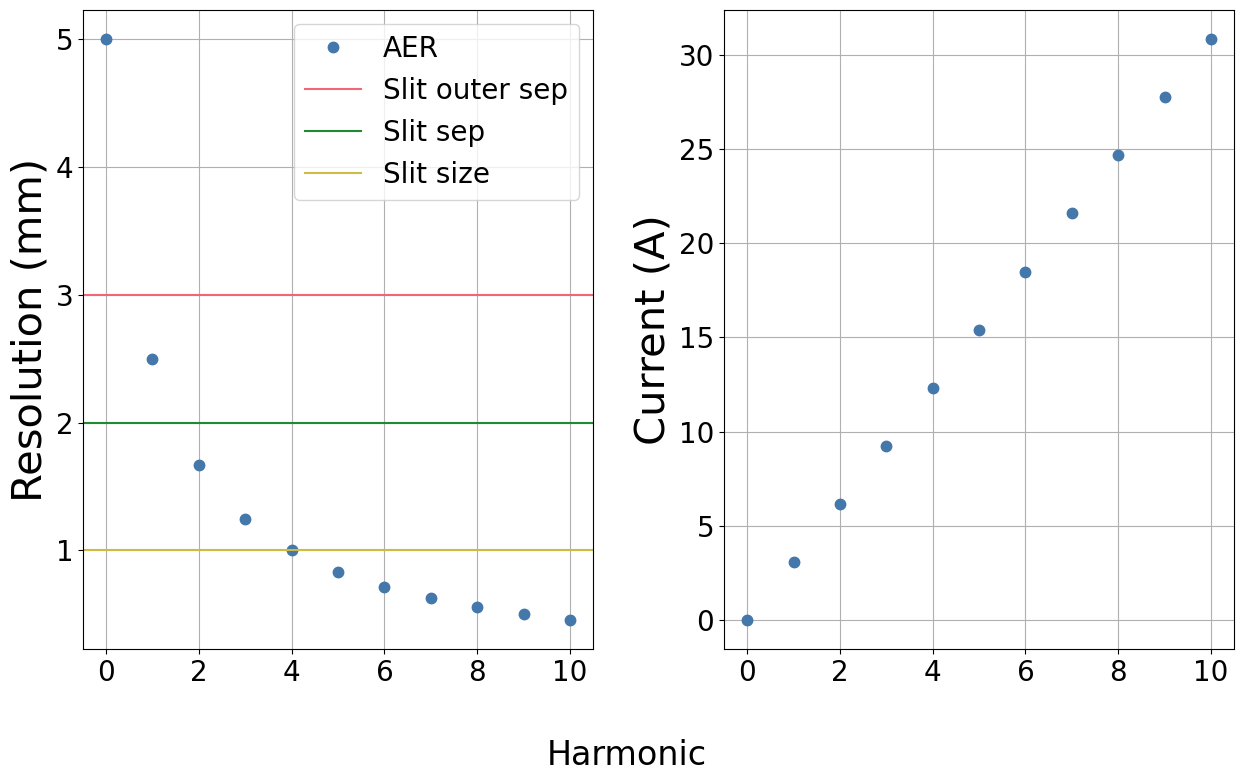

Wavelength: 5.5 p/m  0.055 (Angstroms)
Aperture diameter: 10.0 (mm)
Midpoint distances from MWP to detector: [1.9 1.5] (m)
Geometric resolution: 5.0 (mm) 

MWP currents for first and last harmonic: [ 3.083 30.828] (amps)


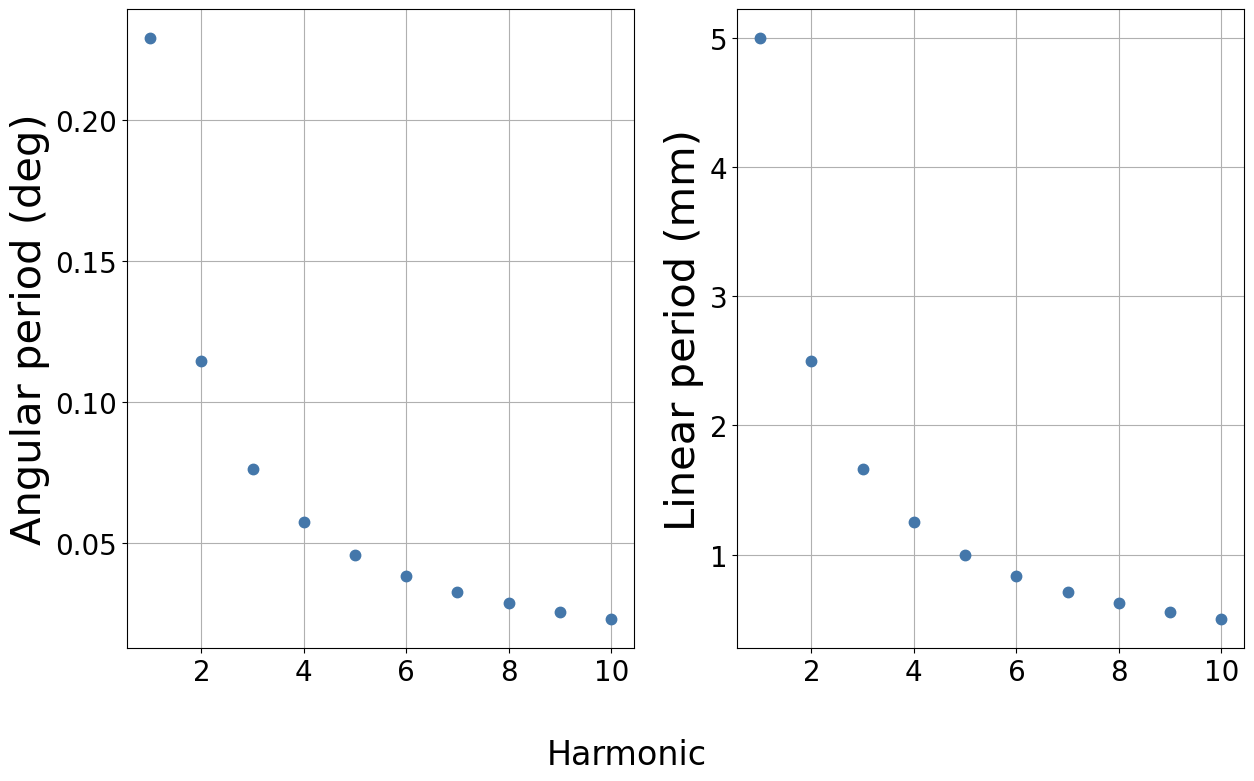

Polarizer axis: [1.0, 0.0, 0.0] 

Detector size: [15.0, 15.0] (mm)
[x,y] bin number: [37, 9]
[x,y] bin size: [0.405, 1.667] (mm) 

--------------------------------------------------------------------------------
double delta_lambda  = 0.055  // Wavelength spread [AA]
int    low_count     = 0      // if true flips analyzer direction [N/A]
int    all_off       = 0      // if true turns off all MWPs [N/A]
double cur1          = 0.0    // MWP1 current [Amps]
double cur2          = -0.0   // MWP2 current [Amps]
double polx          = 1.0    // x-component of polarizer [N/A]
double poly          = 0.0    // y-component of polarizer [N/A]
double polz          = 0.0    // z-component of polarizer [N/A]
--------------------------------------------------------------------------------
COMPONENT src = Source_sam(
  radius = 0.005, // [m]
  dist = 2.5, // [m]
  focus_xw = 0.015, // [m]
  focus_yh = 0.015, // [m]
  lambda0 = 5.5, // [AA]
  dlambda = delta_lambda, // [AA]
  I1 = 10000000000.0 // [1/(

'AER.add_component("hdiv","Monitor_nD", AT=[det_x_offset/1e3, 0, Ld], RELATIVE="origin")\nAER.set_component_parameter("hdiv", {"xwidth":0.1, "yheight":0.1,     "options":hdiv_det, "filename":hdiv_file})\nAER.print_component("hdiv")\n\nAER.add_component("vdiv","Monitor_nD", AT=[det_x_offset/1e3, 0, Ld + 1e-6], RELATIVE="origin")\nAER.set_component_parameter("vdiv", {"xwidth":0.1, "yheight":0.1,     "options":vdiv_det, "filename":vdiv_file})\nAER.print_component("vdiv")'

In [4]:
lam = 5.5  #wavelength (AA)
dl = lam*.01
ap_dia = 10.0 #aperature diameter (mm)

strength = 2.5e-3 #mT per amp, experimental
MWP_parm = {'FI0':0.,'a':strength*2,'b':strength*2,'c':.0001,'d':-.22}
MWP_dim = {'x':.02,'y':.02,'z':.1}
CG_dim = {'x':.02,'y':.02,'z':.3}
LG_parm = {'B0':0.0,'Bx':0.0,'By':0.0,'Bz':0.0}

MWP_sep, Ls, Ld = .4, 1.25, 2.5 #beamline parameters (m)
dists = {'pol':.0,'G1':.3,'P1':.55,'CG':.65,'P2':.95,'ana':1.15,'sam':Ls,'det':Ld}
assert math.isclose(dists['P2'] - dists['P1'], MWP_sep,rel_tol=1e-2), 'Prisms too far apart!'
L = np.array([Ld-dists['P1']-MWP_dim['z']/2,Ld-dists['P2']-MWP_dim['z']/2])
L1, L2 = L #naming the distances

slit_width,slit_hieght,slit_num,slit_offset = 1.,10.,11,.5 #mask parameters (mm)
slit_inner,slit_outer = 22.,40.

res = dists['sam'] / (dists['det'] / ap_dia) #geometric resolution (mm)
harms = np.arange(0,11) #first 10 harmonics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_width,plot_height))
ax1.plot(harms,res/(1+harms),'.',ms=15,label='AER')
ax1.axhline(y=3., label='Slit outer sep',color='C1')
ax1.axhline(y=2., label='Slit sep',color='C2')
ax1.axhline(y=1., label='Slit size',color='C3')
ax1.set(ylabel='Resolution (mm)')
ax2.plot(harms,get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L),'.',ms=15)
ax2.set(ylabel='Current (A)')
ax1.legend()
fig.supxlabel("Harmonic")
plt.tight_layout()
plt.show()

print(f'Wavelength: {lam} p/m  {round(dl,3)} (Angstroms)')
print(f'Aperture diameter: {ap_dia} (mm)')
print(f'Midpoint distances from MWP to detector: {np.round(L,3)} (m)')
print(f'Geometric resolution: {round(res, 3)} (mm) \n')

c1 = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L) #currents (amps)
c2 = -c1
print(f'MWP currents for first and last harmonic: {np.round([c1[1],c1[-1]],3)} (amps)')

per_rad = abs(2*np.pi/(CL*lam*MWP_parm['a']*(c1[1:]*L1 + c2[1:]*L2)))
per_lin = np.round([res/i for i in harms[1:]],3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_width,plot_height))
ax1.plot(harms[1:],per_rad*180/np.pi,'.',ms=15)
ax1.set(ylabel='Angular period (deg)')
ax2.plot(harms[1:],per_lin,'.',ms=15)
ax2.set(ylabel='Linear period (mm)')
fig.supxlabel("Harmonic")
plt.tight_layout()
plt.show()

pol_dir = [1,0,0] #direction of polarizer (x,y,z)
pol_dir = [i/np.sqrt(sum([j**2 for j in pol_dir])) for i in pol_dir]
print(f'Polarizer axis: {[round(i,3) for i in pol_dir]} \n')

det_res = .4 #Anger camera bin size (mm)
det_x,det_y = 1.5*ap_dia,1.5*ap_dia
bin_x,bin_y = int(det_x/det_res),int(det_y/(4*det_res)) #less resolution in y
print(f'Detector size: {[round(i,3) for i in [det_x,det_y]]} (mm)')
print(f'[x,y] bin number: {[round(i,3) for i in [bin_x,bin_y]]}')
print(f'[x,y] bin size: {[round(i,3) for i in [det_x/bin_x,det_y/bin_y]]} (mm) \n')

sam_ang,sam_offset = 0.0,0.0 #angular and linear offset (degs and mm)

hdiv_pre_det, vdiv_pre_det = '', ''
hdiv_post_det, vdiv_post_det = '', ''
hdiv_pre_file, vdiv_pre_file = "\"AER_hdiv_pre.dat\"", "\"AER_vdiv_pre.dat\""
hdiv_post_file, vdiv_post_file = "\"AER_hdiv_post.dat\"", "\"AER_vdiv_post.dat\""
twoD_file = "\"AER_2D.dat\""

print("-"*80)     #Start of instrument definition
AER = ms.McStas_instr('AER_HFIR_2023', author = 'Sam McKay', origin = 'Indiana University')
delta_lambda = AER.add_parameter("double", "delta_lambda", value = dl, comment="Wavelength spread [AA]")
low_count = AER.add_parameter("int", "low_count", value = 0, comment="if true flips analyzer direction [N/A]")
all_off = AER.add_parameter("int", "all_off", value = 0, comment="if true turns off all MWPs [N/A]")
cur1 = AER.add_parameter("double", "cur1", value = c1[0], comment="MWP1 current [Amps]")
cur2 = AER.add_parameter("double", "cur2", value = c2[0], comment="MWP2 current [Amps]")
polx = AER.add_parameter("double", "polx", value = pol_dir[0], comment="x-component of polarizer [N/A]")
poly = AER.add_parameter("double", "poly", value = pol_dir[1], comment="y-component of polarizer [N/A]")
polz = AER.add_parameter("double", "polz", value = pol_dir[2], comment="z-component of polarizer [N/A]")
AER.show_parameters()

print("-"*80)    #Source and polarizer (collimation included via source parameters):
AER.add_component("origin","Progress_bar")
AER.add_component("arm","Arm", AT=[0,0,0], RELATIVE="origin")

src = AER.add_component("src","Source_sam", AT=[0,0,0], RELATIVE="origin")
src.set_parameters(radius=ap_dia/2e3, I1=1e10, lambda0=lam, dlambda="delta_lambda", \
                   focus_xw=det_x/1e3, focus_yh=det_y/1e3, dist=Ld)
print(src)

pol = AER.add_component("pol","Set_pol", AT=[0,0,1e-6], RELATIVE="origin")
pol.set_parameters(px="polx", py="poly", pz="polz")
print(pol)

print("-"*80)    #Magnetic Wollaston prisms:
MWP1 = AER.add_component("MWP1","Pol_MWP_v3", AT=[0,0,dists['P1']], RELATIVE="origin")
MWP1.set_parameters(xwidth=MWP_dim['x'], yheight=MWP_dim['y'], zdepth=MWP_dim['z'], \
                    current="cur1*(1-all_off)")
print(MWP1)

MWP2 = AER.add_component("MWP2","Pol_MWP_v3", AT=[0,0,dists['P2']], RELATIVE="origin")
MWP2.set_parameters(xwidth=MWP_dim['x'], yheight=MWP_dim['y'], zdepth=MWP_dim['z'], \
                    current="cur2*(1-all_off)")
print(MWP2)

print("-"*80)    #Analyzer and slit pattern (sample):
ana = AER.add_component("ana","PolAnalyser_ideal", AT=[0, 0, dists['ana']], RELATIVE="origin")
ana.set_parameters(mx="polx*(1-2*low_count)", my="poly*(1-2*low_count)", mz="polz*(1-2*low_count)")
print(ana)

sam = AER.add_component("sam","grating_mask", AT=[sam_offset*1e-3*(1-np.cos(sam_ang/180*np.pi)),\
                                                  np.sin(sam_ang/180*np.pi), dists['sam']], RELATIVE="origin")
sam.set_parameters(outer=slit_outer,inner=slit_inner,Tr_len=slit_width,Ab_len=slit_width,\
                   offset=slit_offset,slits=slit_num)
print(sam)

print("-"*80)    #2D and post-sample divergence detectors
det = AER.add_component("det","PSD_monitor", AT=[0, 0, Ld], RELATIVE="origin")
det.set_parameters(nx=bin_x, ny=bin_y, filename=twoD_file, xwidth=det_x*1e-3, yheight=det_y*1e-3)
print(det)

print("-"*80)    #Final instrument summary:
AER.show_components()

"""AER.add_component("hdiv","Monitor_nD", AT=[det_x_offset/1e3, 0, Ld], RELATIVE="origin")
AER.set_component_parameter("hdiv", {"xwidth":0.1, "yheight":0.1, \
    "options":hdiv_det, "filename":hdiv_file})
AER.print_component("hdiv")

AER.add_component("vdiv","Monitor_nD", AT=[det_x_offset/1e3, 0, Ld + 1e-6], RELATIVE="origin")
AER.set_component_parameter("vdiv", {"xwidth":0.1, "yheight":0.1, \
    "options":vdiv_det, "filename":vdiv_file})
AER.print_component("vdiv")"""

***
## Simulation scans
***

In [5]:
ray_num=1e5

def do_run(ray_num, harms):
    """Performs McStas calcuation. Returns list of currents, intensities, and errors."""
    curs = []
    hc_runs, hc_err = [[],[]]
    lc_runs, lc_err = [[],[]]
    
    get_lc = True    #Needed for polarization calculation

    for harm in harms:
        c1 = get_SS_focus(harm,Ls,res,lambda0,MWP_str,L)
        c2, c3, c4 = -c1, -c1, c1
        curs.append([c1,c2,c3,c4])
        print('Harmonic = ', harm)
        print('Currents = ', [round(i,3) for i in [c1,c2,c3,c4]])

        AER.settings(output_path='AER_hc'+str(round(c1,2)), ncount=ray_num)
        low_count.value, all_off.value, cur1.value, cur2.value, cur3.value, cur4.value = 0, 0, c1, c2, c3, c4
        AER_hc = AER.backengine()
        hc_runs.append(AER_hc[0].Intensity)
        hc_err.append(AER_hc[0].Error)
        ms.make_sub_plot(AER_hc)

        if (get_lc):    #not necessary for Fourier reconstruction
            AER.settings(output_path='AER_lc'+str(round(c1,2)))
            low_count.value = 1
            AER_lc = AER.backengine()
            lc_runs.append(AER_lc[0].Intensity)
            lc_err.append(AER_lc[0].Error)
            ms.make_sub_plot(AER_lc)
        print('='*79, '\n')

    AER.settings(output_path='AER_nc', ncount=ray_num)
    all_off.value, low_count.value = 1, 0
    AER_nc = AER.backengine()
    nc_run, nc_err = AER_nc[0].Intensity, AER_nc[0].Error
    ms.make_sub_plot(AER_nc)

    return curs, hc_runs, hc_err, lc_runs, lc_err, nc_run

#curs, hc_runs, hc_err, lc_runs, lc_err, nc_run = do_run(ray_num, harms)

AER.settings(output_path='Simulations\\AER_test', ncount=ray_num)
test_results = AER.backengine()


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\AER_test_0"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]
   printf("\

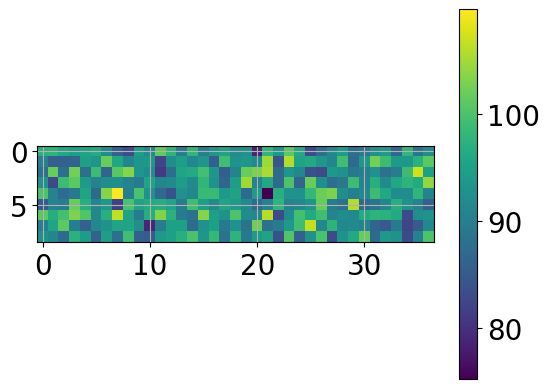

In [6]:
data = test_results[0].Intensity
plt.imshow(data)
plt.colorbar()
plt.show()

***
## Simulated polarization analysis
***

In [7]:
get_lc = True
plot_pols, plot_intensity_normed, plot_2D_pols, plot_empty = True, True, True, True

xpos = np.linspace(-det_x/2,det_x/2, num=det_bins, endpoint=True)
fine_bins = 200
finer_bins = 1000
xpos_fine = np.linspace(xpos[0], xpos[-1], num=fine_bins, endpoint=True)
xpos_finer = np.linspace(xpos[0], xpos[-1], num=finer_bins, endpoint=True)

sof = 10    #sum offset for detector integration
nc_tot = np.sum(nc_run)    #total zero current run counts

pols = np.array([np.zeros((det_bins,det_bins)) for i in range(len(hc_runs))])
int_pols = np.array([np.zeros(det_bins) for i in range(len(hc_runs))])
fits = np.array([np.zeros(4) for i in range(len(hc_runs))])
fit_err = np.array([np.zeros(4) for i in range(len(hc_runs))])

nic_hc = np.array([np.zeros((det_bins)) for i in range(len(hc_runs))])
nic_lc = np.array([np.zeros((det_bins)) for i in range(len(hc_runs))])
nic_hc_fits = np.array([np.zeros(4) for i in range(len(hc_runs))])
nic_hc_fit_err = np.array([np.zeros(4) for i in range(len(hc_runs))])
nic_lc_fits = np.array([np.zeros(4) for i in range(len(hc_runs))])
nic_lc_fit_err = np.array([np.zeros(4) for i in range(len(hc_runs))])

for i in range(len(hc_runs)): #don't change this!
    for j in range(det_bins):
        for k in range(det_bins):
            if (get_lc):
                pols[i][j][k] = ((hc_runs[i][j][k] - lc_runs[i][j][k])\
                                 /(hc_runs[i][j][k] + lc_runs[i][j][k]))
    
    if (get_lc):    #vertically integrates polarizations
        int_pols[i] = np.sum(pols[i][sof:det_bins-sof:,:]/det_bins, axis=0)
    
    guess = [(np.max(int_pols[i])-np.min(int_pols[i]))/2.,2*np.pi/res*(i + 1),0,np.mean(int_pols[i])]
    fit, cov = sp.optimize.curve_fit(simple_cos, xpos, int_pols[i], p0=guess)
    fits[i] = fit
    fit_err[i] = np.sqrt(np.diag(cov))
    
    nic_hc[i] = np.sum(hc_runs[i][sof:det_bins-sof:,:], axis=0)/np.sum(nc_run[sof:det_bins-sof:,:], axis=0)
    if (get_lc):
        nic_lc[i] = np.sum(lc_runs[i][sof:det_bins-sof:,:], axis=0)/np.sum(nc_run[sof:det_bins-sof:,:], axis=0)
    
    guess = [(np.max(nic_hc[i])-np.min(nic_hc[i]))/2.,2*np.pi/res*(i + 1),0,np.mean(nic_hc[i])]
    fit, cov = sp.optimize.curve_fit(simple_cos, xpos, nic_hc[i], p0=guess)
    nic_hc_fits[i] = fit
    nic_hc_fit_err[i] = np.sqrt(np.diag(cov))
    
    if (get_lc):
        guess = [(np.max(nic_lc[i])-np.min(nic_lc[i]))/2.,2*np.pi/res*(i + 1),np.pi,np.mean(nic_lc[i])]
        fit, cov = sp.optimize.curve_fit(simple_cos, xpos, nic_lc[i], p0=guess)
        nic_lc_fits[i] = fit
        nic_lc_fit_err[i] = np.sqrt(np.diag(cov))
    
    if(plot_pols):
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.plot(xpos, int_pols[i], 'o', ms=20, label='Harmonic: '+str(harms[i]), color='C0')
        plt.plot(xpos_fine, simple_cos(xpos_fine, *fits[i]), '-', linewidth=4, label='Fit', color='C0')
        plt.xlabel('x [mm]')
        plt.ylabel('Polarization')
        plt.legend()
        plt.show()
        
        print("amp, freq, phase, shim: ", [round(j,5) for j in fits[i]])
        print("\t errors: ", [round(j,5) for j in fit_err[i]])
        
    if(plot_intensity_normed):
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('NIC of Harmonic '+str(harms[i]))
        plt.plot(xpos, nic_hc[i],'o', label='High count', ms=10, color='C0')
        plt.plot(xpos_fine, simple_cos(xpos_fine, *nic_hc_fits[i]), '-', linewidth=4, color='C0')
        if (get_lc):
            plt.plot(xpos, nic_lc[i],'o', label='Low count', ms=10, color='C1')
            plt.plot(xpos_fine, simple_cos(xpos_fine, *nic_lc_fits[i]), '-', linewidth=4, color='C1')
        plt.xlabel('x [mm]')
        plt.ylabel('Normed Integrated Counts')
        plt.legend()
        plt.grid('On')
        plt.show()
    
        print("(HC) amp, freq, phase, shim: ", [round(j,5) for j in nic_hc_fits[i]])
        print("\t errors: ", [round(j,5) for j in nic_hc_fit_err[i]])
        if (get_lc):
            print("(LC) amp, freq, phase, shim: ", [round(j,5) for j in nic_lc_fits[i]])
            print("\t errors: ", [round(j,5) for j in nic_lc_fit_err[i]])
    
    if(plot_2D_pols):
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title('Pol. of Harmonic '+str(harms[i]))
        plt.imshow(pols[i], origin='lower', vmin=-1, vmax=1)
        plt.xlabel('x [mm]')
        plt.ylabel('y [mm]')
        plt.colorbar()
        plt.show()

if(plot_empty):
    fig = plt.figure(figsize=(plot_width,plot_height))
    plt.title('Traditional Normalized Radiograph')
    plt.plot(xpos, [np.sum(nc_run[i,:], axis=0) for i in range(det_bins)]/(np.sum(nc_run)*res*2/3),'o', label='Zero current', ms=10)
    plt.xlabel('x [mm]')
    plt.ylabel('Normed Integrated Counts')
    plt.legend()
    plt.grid('On')
    plt.show()

NameError: name 'nc_run' is not defined

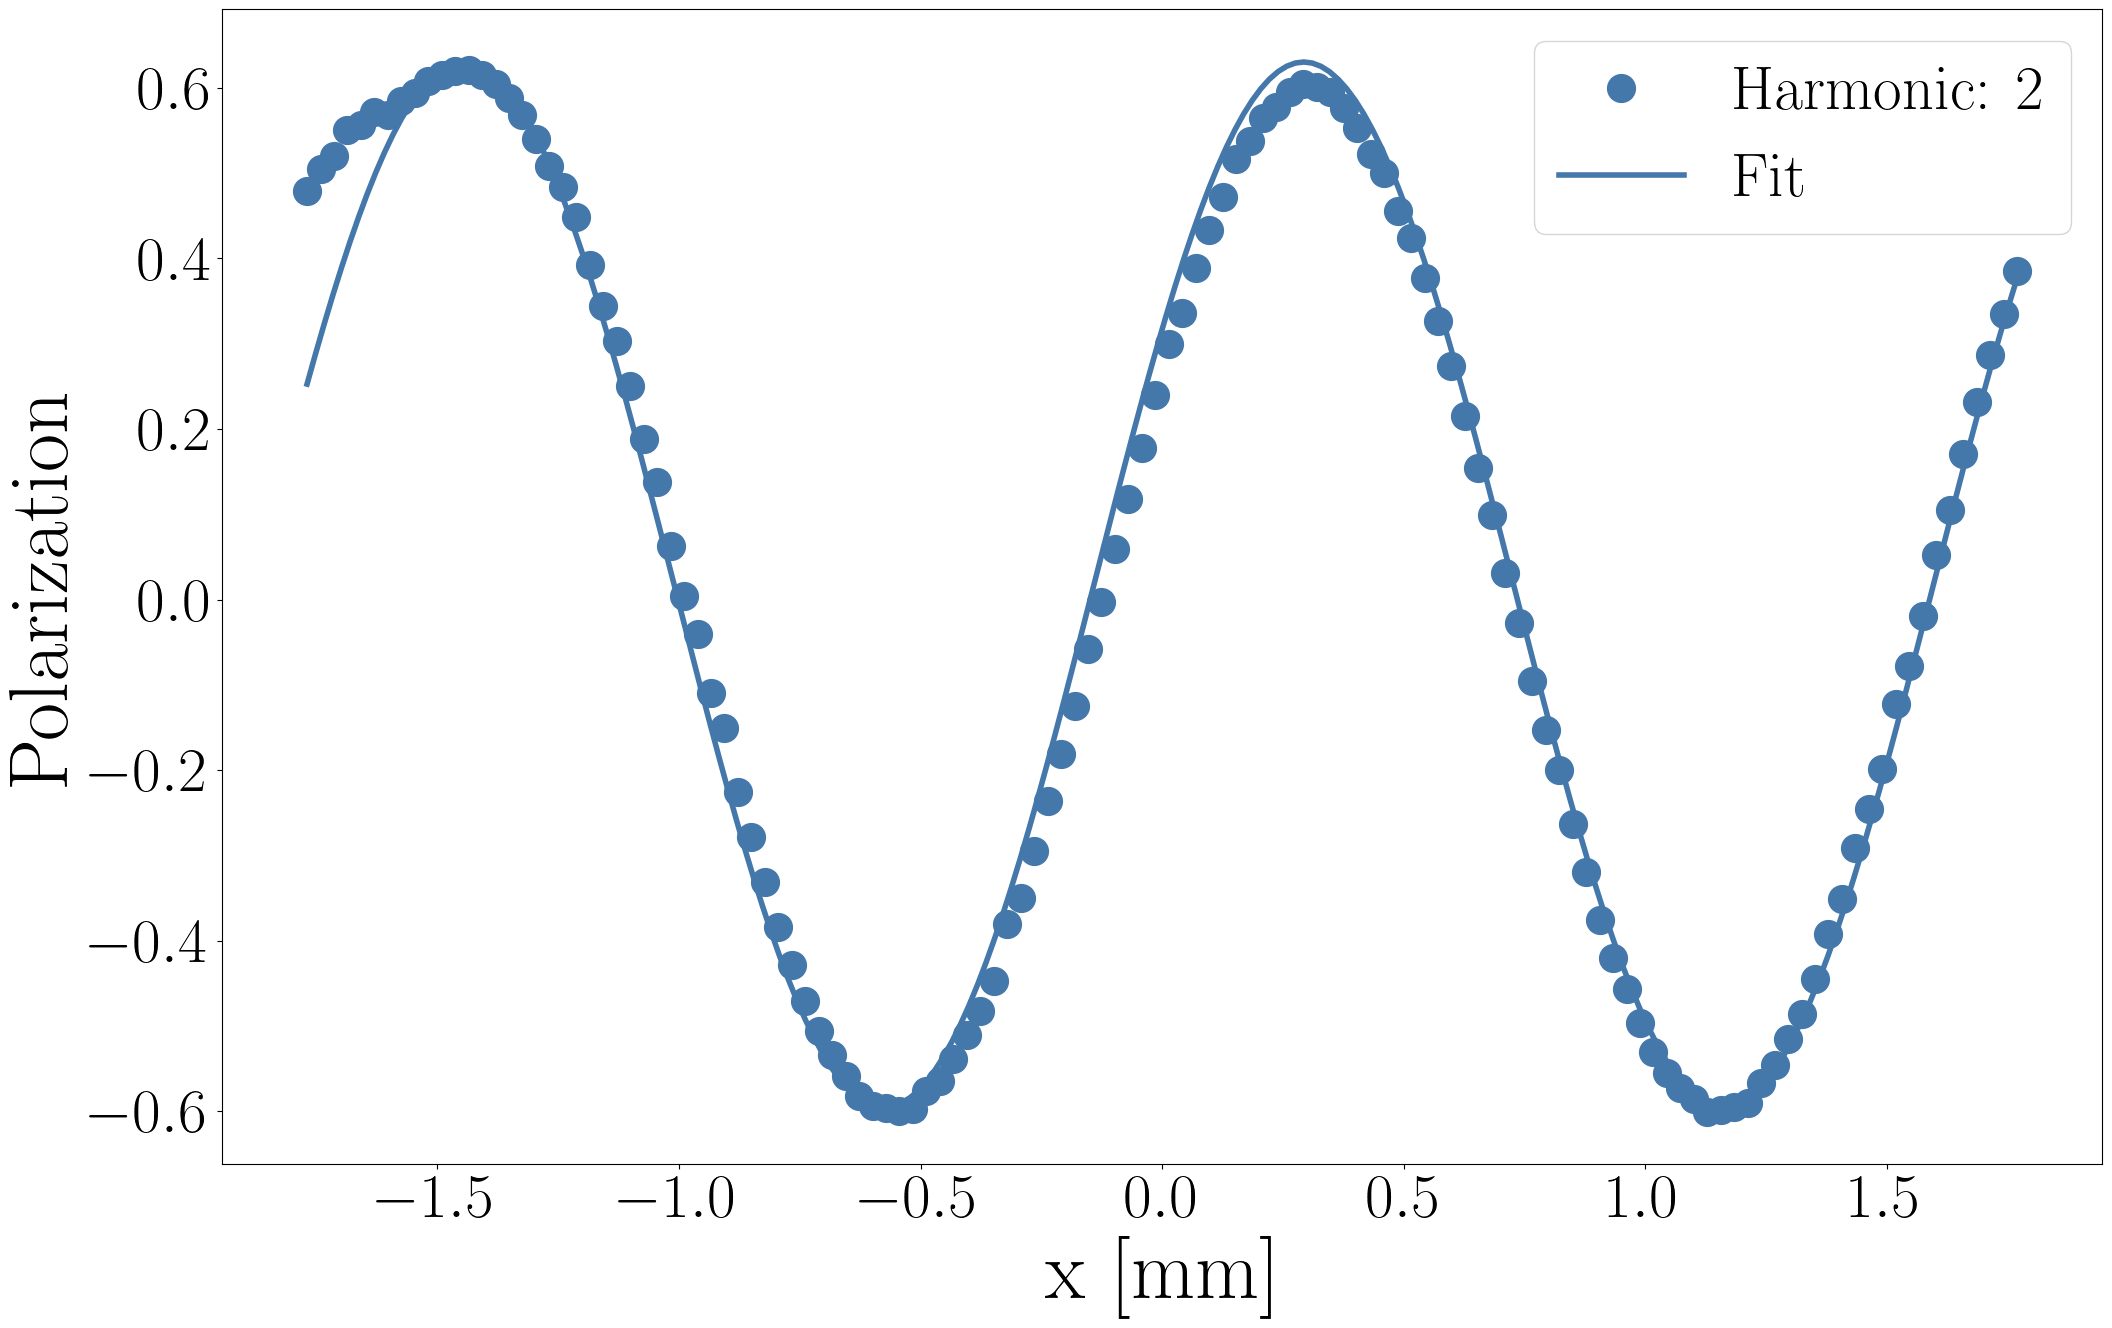

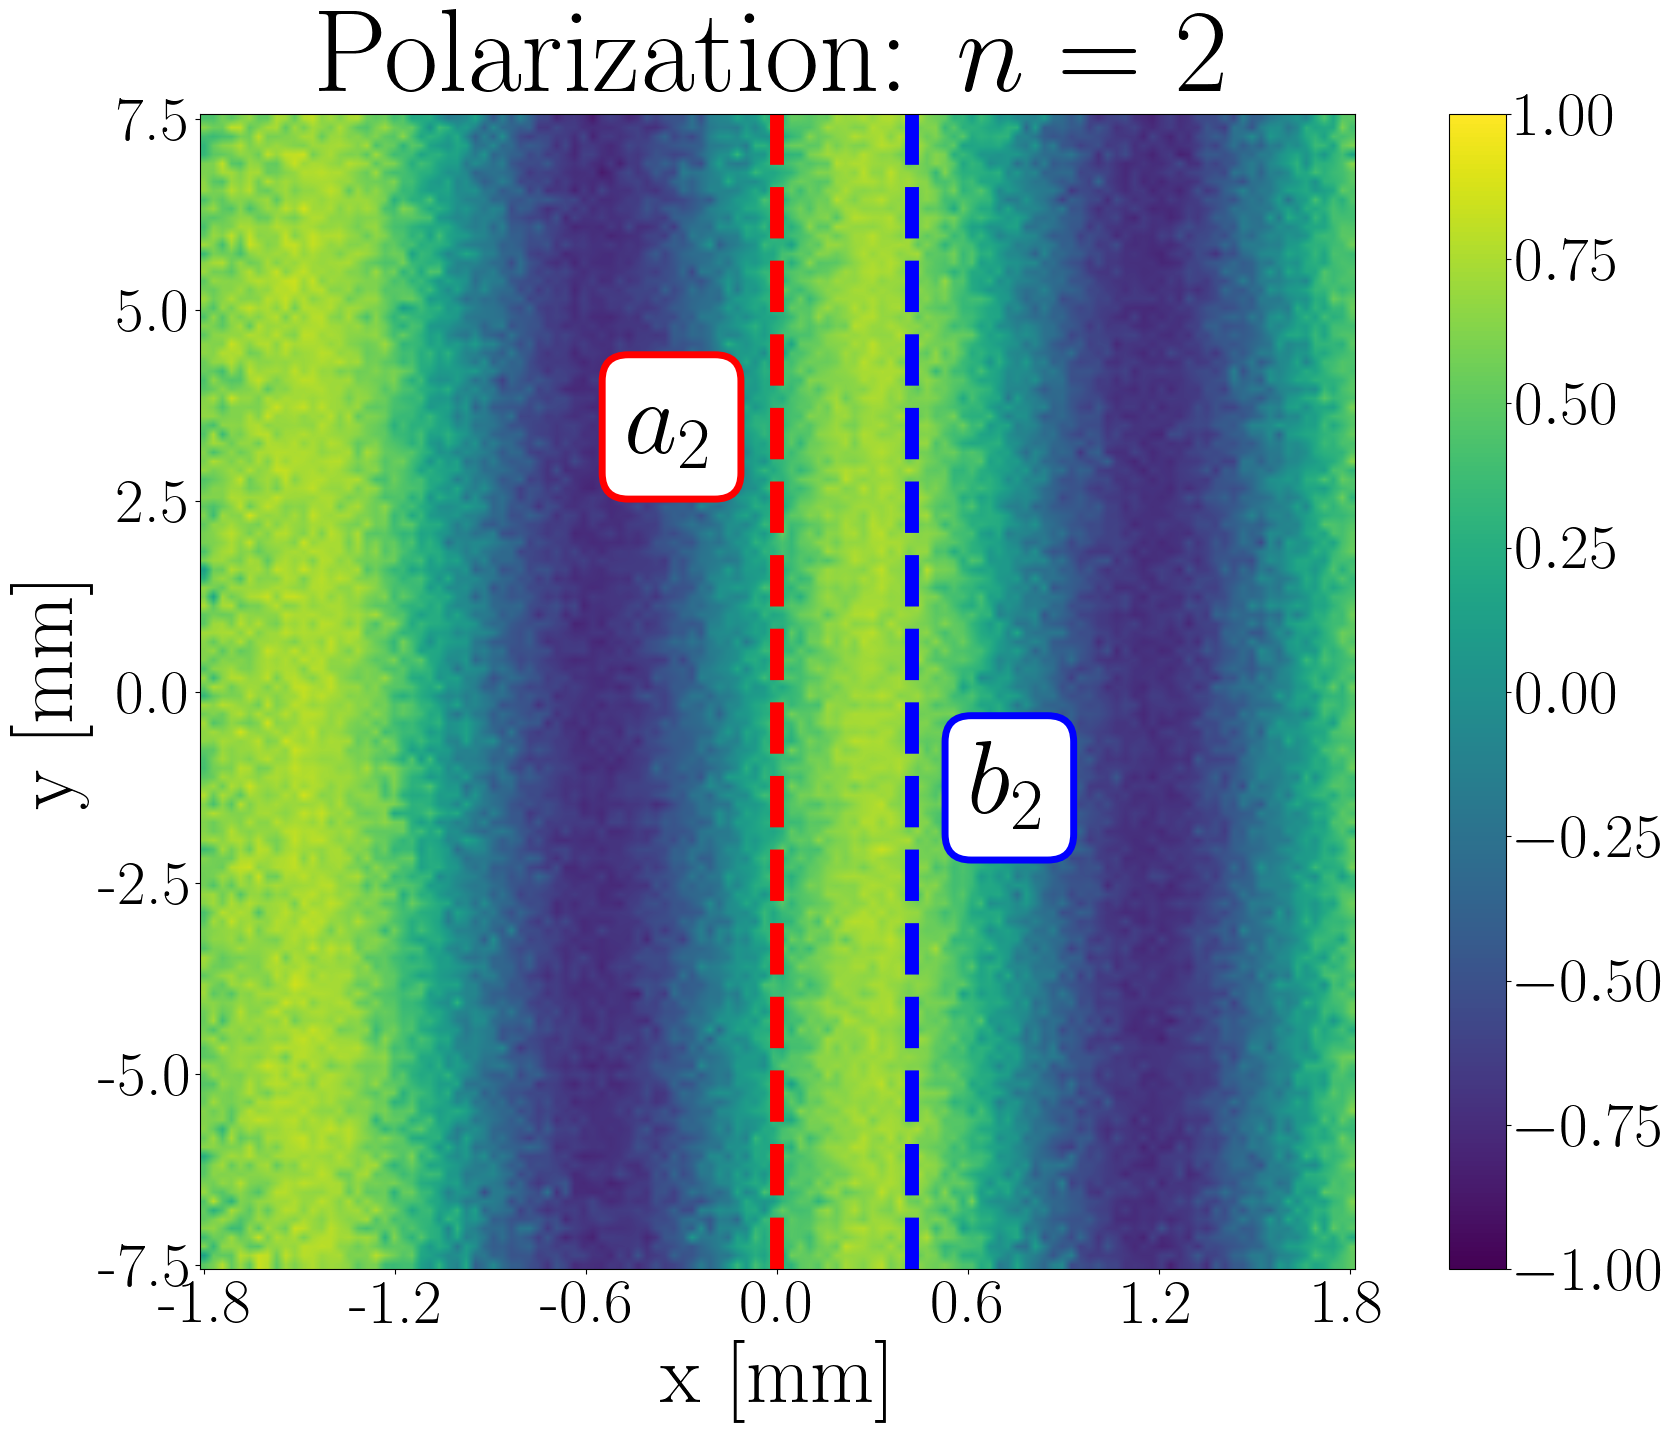

In [18]:
fig = plt.figure(figsize=(plot_width,plot_height))
plt.plot(xpos, int_pols[1], 'o', ms=20, label='Harmonic: '+str(harms[1]), color='C0')
plt.plot(xpos_fine, simple_cos(xpos_fine, *fits[1]), '-', linewidth=4, label='Fit', color='C0')
plt.xlabel('x [mm]')
plt.ylabel('Polarization')
plt.legend()
plt.show()

#print(np.where(abs(int_pols[1])<.06))

fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
plt.title(r'Polarization: $n=2$')
plt.imshow(pols[1], origin='lower', vmin=-1, vmax=1, interpolation='bilinear')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axvline(x=63.5, linewidth=10, linestyle='--', color='red')
plt.axvline(x=78.5, linewidth=10, linestyle='--', color='blue') #0.8345045
plt.text(47, 90, r'$a_2$', size=75, \
             bbox=dict(facecolor='white', linewidth=5, edgecolor='red', boxstyle='round,pad=.25'))
plt.text(85, 50, r'$b_2$', size=75, \
             bbox=dict(facecolor='white', linewidth=5, edgecolor='blue', boxstyle='round,pad=.25'))
ax.set_xticks(np.linspace(0,det_bins-1,7))
ax.set_yticks(np.linspace(0,det_bins-1,7))
ax.set_xticklabels([round(i,1) for i in np.linspace(-det_x/2,det_x/2,7)])
ax.set_yticklabels([round(i,1) for i in np.linspace(-det_y/2,det_y/2,7)])
plt.colorbar()
plt.show()

***
## Theoretical Solution:
***

Normalization factor (av):  0.0004
Harmonic  1  Ana - Num= 0.06981385886254043
Harmonic  2  Ana - Num= 0.1655301875668842
Harmonic  3  Ana - Num= 0.20469557791112936
Harmonic  4  Ana - Num= 0.037963279349184476
Harmonic  5  Ana - Num= -0.2653125559673804


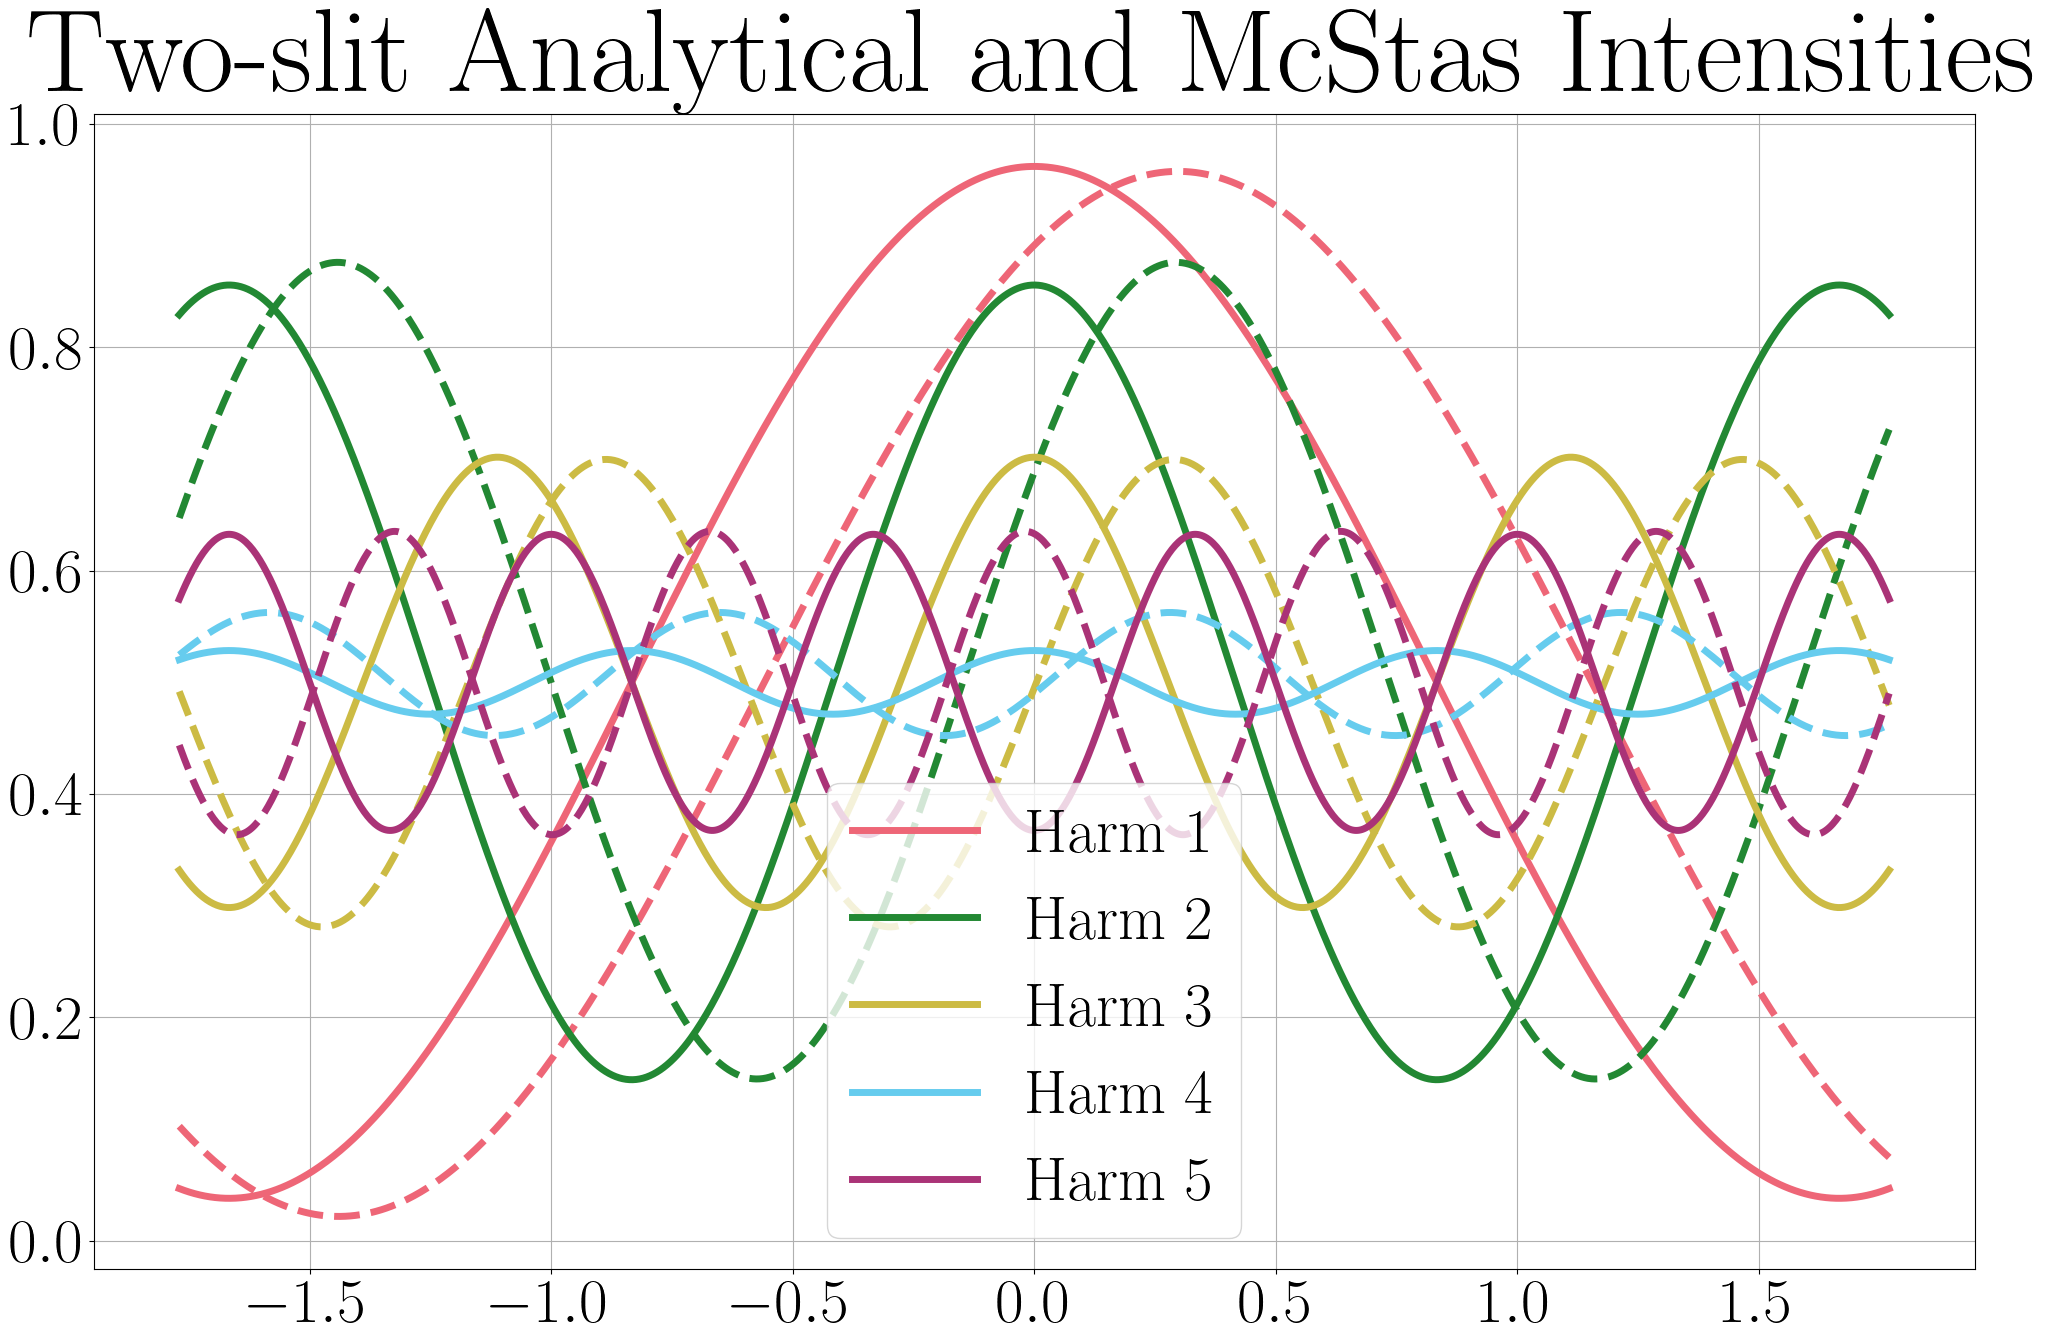

Theoretical values: 
 [0.24, 0.222, 0.171, 0.097, 0.014, -0.064, -0.122, -0.154, -0.158, -0.136]
Non-normed Numerical values: 
 [0.5, 0.785, 0.381, -0.006, -0.019, 0.265, 0.479, 0.44, 0.151, -0.171] 



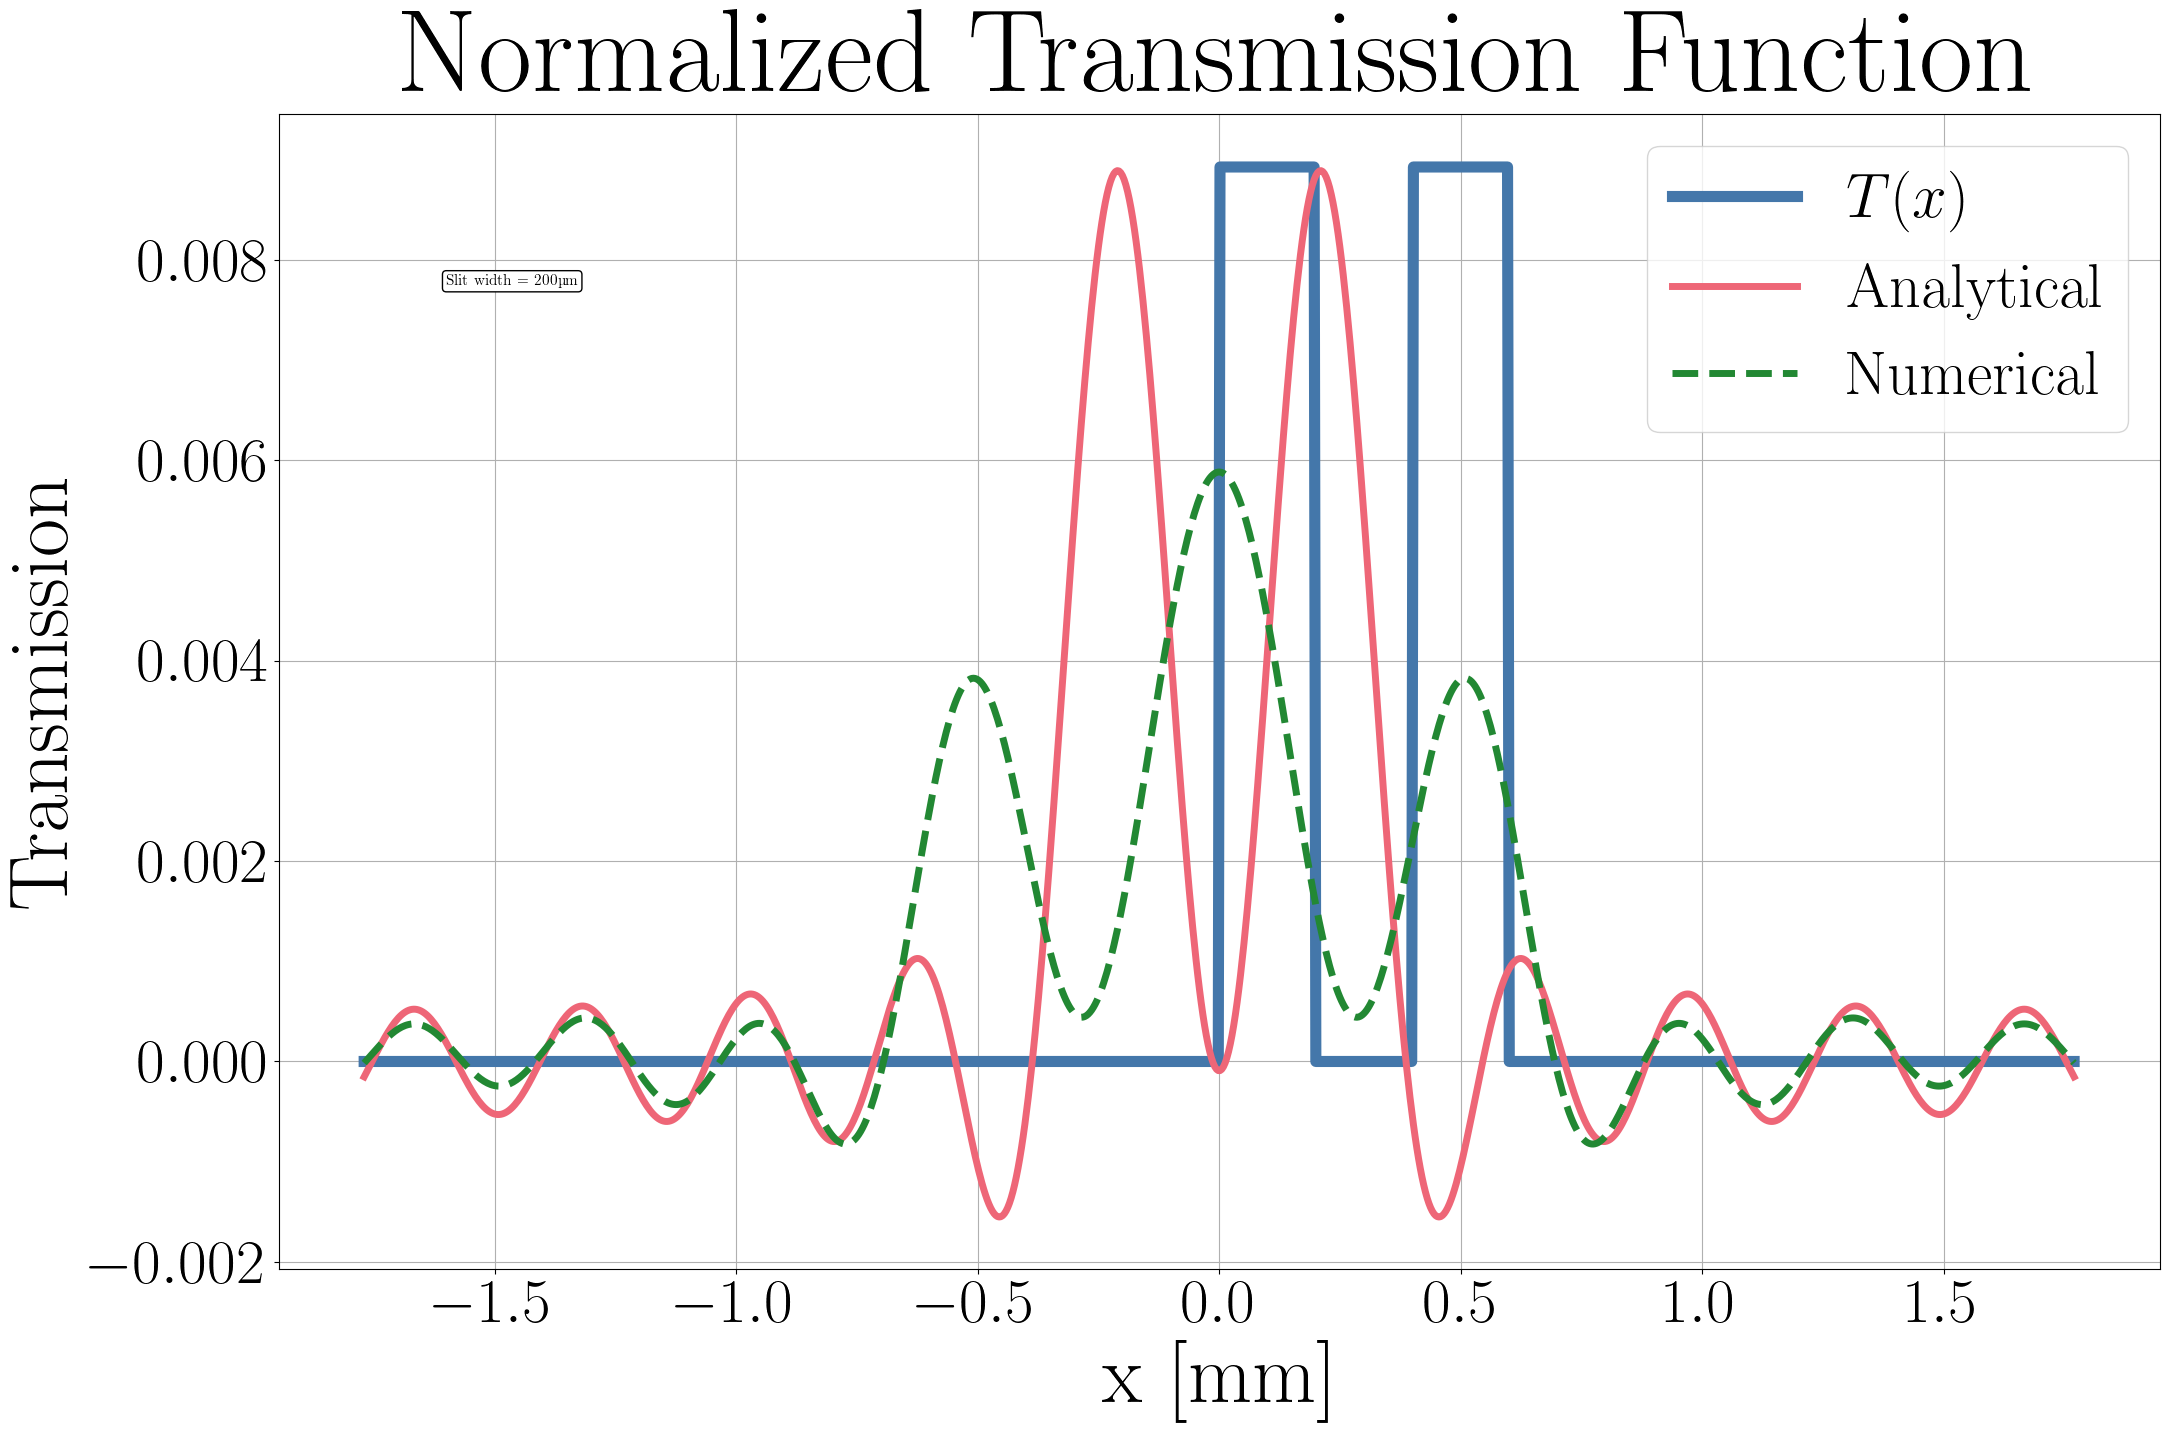

In [31]:
def slit_T(x, width):    #determines the two-slit function
    return np.heaviside(x + 3*width/2 - slit_offset, .5)*np.heaviside(-width/2 - x + slit_offset, .5) + \
            np.heaviside(x - width/2 - slit_offset, .5)*np.heaviside(3*width/2 - x + slit_offset, .5)
def slit_T_inten(x, n, width, R, ls):    #analytical intensity on the detector
    if (n == 0):
        return [2*width/ls for i in range(len(x))]    #constant term
    else:
        return width/ls + R/(np.pi*n*ls)*np.sin(np.pi*n/R*width)*np.cos(2*np.pi*n/R*width)*np.cos(2*np.pi*n/R*x)
def slit_T_coeff(x, n, width, R, ls):    #analytical solution for two-slit Fourier transform
    x0 = 500 #midpoint, hardcoded!
    if (n == 0):
        return 2*ls/R*slit_T_inten(x, 0, width, R, ls)[x0] #2 or 4?
    else:
        return 4*ls/R*slit_T_inten(x, n, width, R, ls)[x0] - slit_T_coeff(x, 0, width, R, ls)

plot_harms, plot_T_com, plot_T_norm_com = True, False, True

norm = np.asarray(slit_T_inten(xpos_finer, 0, slit_x*1e-3, res, Ls*1e3))    #normalize by zero current scan
print('Normalization factor (av): ', round(np.mean(norm),5))

if (plot_harms):
    fig = plt.figure(figsize=(plot_width,plot_height))
    plt.title('Two-slit Analytical and McStas Intensities')
    #for i in range(1,20):    #chooses which harmonics to plot
    for i in range(1,6):
        plt.plot(xpos_finer, slit_T_inten(xpos_finer, i, slit_x*1e-3, res, Ls*1e3)/norm, '-', linewidth=5, \
                 label='Harm '+str(i), color='C'+str(i))
        plt.plot(xpos_finer, simple_cos(xpos_finer, *nic_hc_fits[i-1]), '--', linewidth=5, \
                 color='C'+str(i))
        print('Harmonic ', str(i),' Ana - Num=', (slit_T_inten(xpos_finer, i, slit_x*1e-3, res, Ls*1e3)/norm)[500] - \
             simple_cos(xpos_finer, *nic_hc_fits[i-1])[500])
    plt.legend()
    plt.grid('on')
    plt.show()
    
cos_vals_ana = [slit_T_coeff(xpos_finer, i, slit_x*1e-3, res, Ls*1e3) for i in range(len(harms)+1)]
print('Theoretical values: \n', [round(i,3) for i in cos_vals_ana])
cos_vals_num = 2*np.array([simple_cos(xpos_finer, *nic_hc_fits[i])[500] for i in range(len(harms))]) - 1
cos_vals_num = np.insert(cos_vals_num, 0, 1/2, axis=0)
print('Non-normed Numerical values: \n', [round(i,3) for i in cos_vals_num], '\n')    #num*.24 = ana

recon_harms = 10
recon_ana = [cos_vals_ana[0]/2 + np.sum(np.array([cos_vals_ana[i]*np.cos(2*np.pi*i/res*x) for i in range(1,recon_harms)]), axis=0) \
         for x in xpos_finer]
recon_num = np.asarray([cos_vals_num[0] + np.sum(np.array([cos_vals_num[i]*np.cos(2*np.pi*i/res*x) \
                                for i in range(1,recon_harms)]), axis=0) for x in xpos_finer])

if (plot_T_com):
    fig = plt.figure(figsize=(plot_width,plot_height))
    plt.title("T(x) Recon.")
    plt.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3), linewidth=5, label='$T(y)$')
    plt.plot(xpos_finer, recon_ana, '-', linewidth=5, label='Ana. Recon')
    plt.plot(xpos_finer, recon_num, '--', linewidth=5, label='Num. Recon')
    plt.legend()
    plt.grid('on')
    plt.show()

if (plot_T_norm_com):
    fig = plt.figure(figsize=(plot_width,plot_height))
    plt.title("Normalized Transmission Function")
    plt.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
    plt.plot(xpos_finer, recon_ana/np.sum(recon_ana), '-', linewidth=5, label='Analytical')
    plt.plot(xpos_finer, recon_num/np.sum(recon_num), '--', linewidth=5, label='Numerical')
    plt.text(-1.6, 7.75e-3, r'Slit width = $\num{200}\unit{\micro \meter}$', \
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
    plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
    plt.ylabel('Transmission')
    plt.legend()
    plt.grid('on')
    plt.show()


In [170]:
#Solution animation

def AER_ani(frame):
    frame += 2
    temp_cos_vals_num = 2*np.array([simple_cos(xpos_finer, *nic_hc_fits[i])[500] for i in range(0,frame)]) - 1
    temp_cos_vals_num = np.insert(temp_cos_vals_num, 0, 1/2, axis=0)
    temp_recon_num = np.asarray([temp_cos_vals_num[0] + np.sum(np.array([temp_cos_vals_num[i]*np.cos(2*np.pi*i/res*x) \
                                for i in range(1,frame)]), axis=0) for x in xpos_finer])
    temp_recon_num = temp_recon_num/np.sum(temp_recon_num)
    ax.set_title(r'Reconstruction up to $N ='+str(frame-1)+'$')
    line.set_ydata(temp_recon_num)
    line.set_label(r'$N=$'+str(frame-1))
    plt.text(-1.6, 5e-3, r'$R_{\mathrm{AER}}=\num{'+str(round(res/frame,2))+r'}\unit{\milli \meter}$', \
             fontdict=dict(fontsize=60), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
    plt.legend()
    
fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
ax.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
line, = ax.plot(xpos_finer, np.zeros(len(xpos_finer)), linewidth=8)
#ax.plot(xpos_finer, np.zeros(len(xpos_finer)), '-', linewidth=5, label='Num. Recon')
#plt.plot(xpos_finer, recon_num/np.sum(recon_num), '--', linewidth=5, label='Num. Recon')
#plt.text(-1.6, 7.75e-3, r'Slit width = $\num{200}\unit{\micro \meter}$', \
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
ax.set_ylim(-.002, .010)
plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
plt.ylabel('Transmission')
plt.legend()
plt.grid('on')

F_tot = 6
F_int = 200
FPS = .5
anim = FuncAnimation(fig, AER_ani, frames=F_tot, interval=F_int, repeat=False)
anim.save('Aer_soln_FPS'+str(FPS)+'_frames'+str(F_tot)+'.gif', writer='pillow', fps=FPS)
plt.close()
print('Ding!')


Ding!


In [175]:
#Solution animation

def AER_ani(frame):
    frame += 7
    temp_cos_vals_num = 2*np.array([simple_cos(xpos_finer, *nic_hc_fits[i])[500] for i in range(0,frame)]) - 1
    temp_cos_vals_num = np.insert(temp_cos_vals_num, 0, 1/2, axis=0)
    temp_recon_num = np.asarray([temp_cos_vals_num[0] + np.sum(np.array([temp_cos_vals_num[i]*np.cos(2*np.pi*i/res*x) \
                                for i in range(1,frame)]), axis=0) for x in xpos_finer])
    temp_recon_num = temp_recon_num/np.sum(temp_recon_num)
    ax.set_title(r'Reconstruction up to $N ='+str(frame-1)+'$')
    line.set_ydata(temp_recon_num)
    line.set_label(r'$N=$'+str(frame-1))
    plt.text(-1.6, 5e-3, r'$R_{\mathrm{AER}}=\num{'+f"{round(res/frame,2):.2f}"+r'}\unit{\milli \meter}$', \
             fontdict=dict(fontsize=60), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
    plt.legend()
    
fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
ax.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
line, = ax.plot(xpos_finer, np.zeros(len(xpos_finer)), linewidth=8)
#ax.plot(xpos_finer, np.zeros(len(xpos_finer)), '-', linewidth=5, label='Num. Recon')
#plt.plot(xpos_finer, recon_num/np.sum(recon_num), '--', linewidth=5, label='Num. Recon')
#plt.text(-1.6, 7.75e-3, r'Slit width = $\num{200}\unit{\micro \meter}$', \
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
ax.set_ylim(-.002, .011)
plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
plt.ylabel('Transmission')
plt.legend()
plt.grid('on')

F_tot = 10
F_int = 200
FPS = .5
anim = FuncAnimation(fig, AER_ani, frames=F_tot, interval=F_int, repeat=False)
anim.save('Aer_soln_higher_FPS'+str(FPS)+'_frames'+str(F_tot)+'.gif', writer='pillow', fps=FPS)
plt.close()
print('Ding!')


Ding!


X pos:  [8.34504505e-01 4.16366366e-01 2.78168168e-01 2.07297297e-01
 1.68318318e-01 1.39969970e-01 1.18708709e-01 1.04534535e-01
 9.39039039e-02 8.99625932e+02 9.02556302e+02 1.32000000e+03
 1.32000000e+03 1.65000000e+02 1.32000000e+03 1.55277778e+02
 1.33139090e+03 6.50556828e+02 1.32000000e+03 1.42455376e+03]
I_n:  [7.54024338e-01 8.40736214e-01 6.99291372e-01 5.55910396e-01
 4.68955528e-01 5.70952631e-01 7.36839006e-01 8.19818184e-01
 7.65605642e-01 8.99625932e+02 9.02556302e+02 1.32000000e+03
 1.32000000e+03 1.65000000e+02 1.32000000e+03 1.55277778e+02
 1.33139090e+03 6.50556828e+02 1.32000000e+03 1.42455376e+03]
b_n:  [ 5.08048676e-01  6.81472427e-01  3.98582743e-01  1.11820793e-01
 -6.20889439e-02  1.41905262e-01  4.73678013e-01  6.39636369e-01
  5.31211283e-01  8.99625932e+02  9.02556302e+02  1.32000000e+03
  1.32000000e+03  1.65000000e+02  1.32000000e+03  1.55277778e+02
  1.33139090e+03  6.50556828e+02  1.32000000e+03  1.42455376e+03]


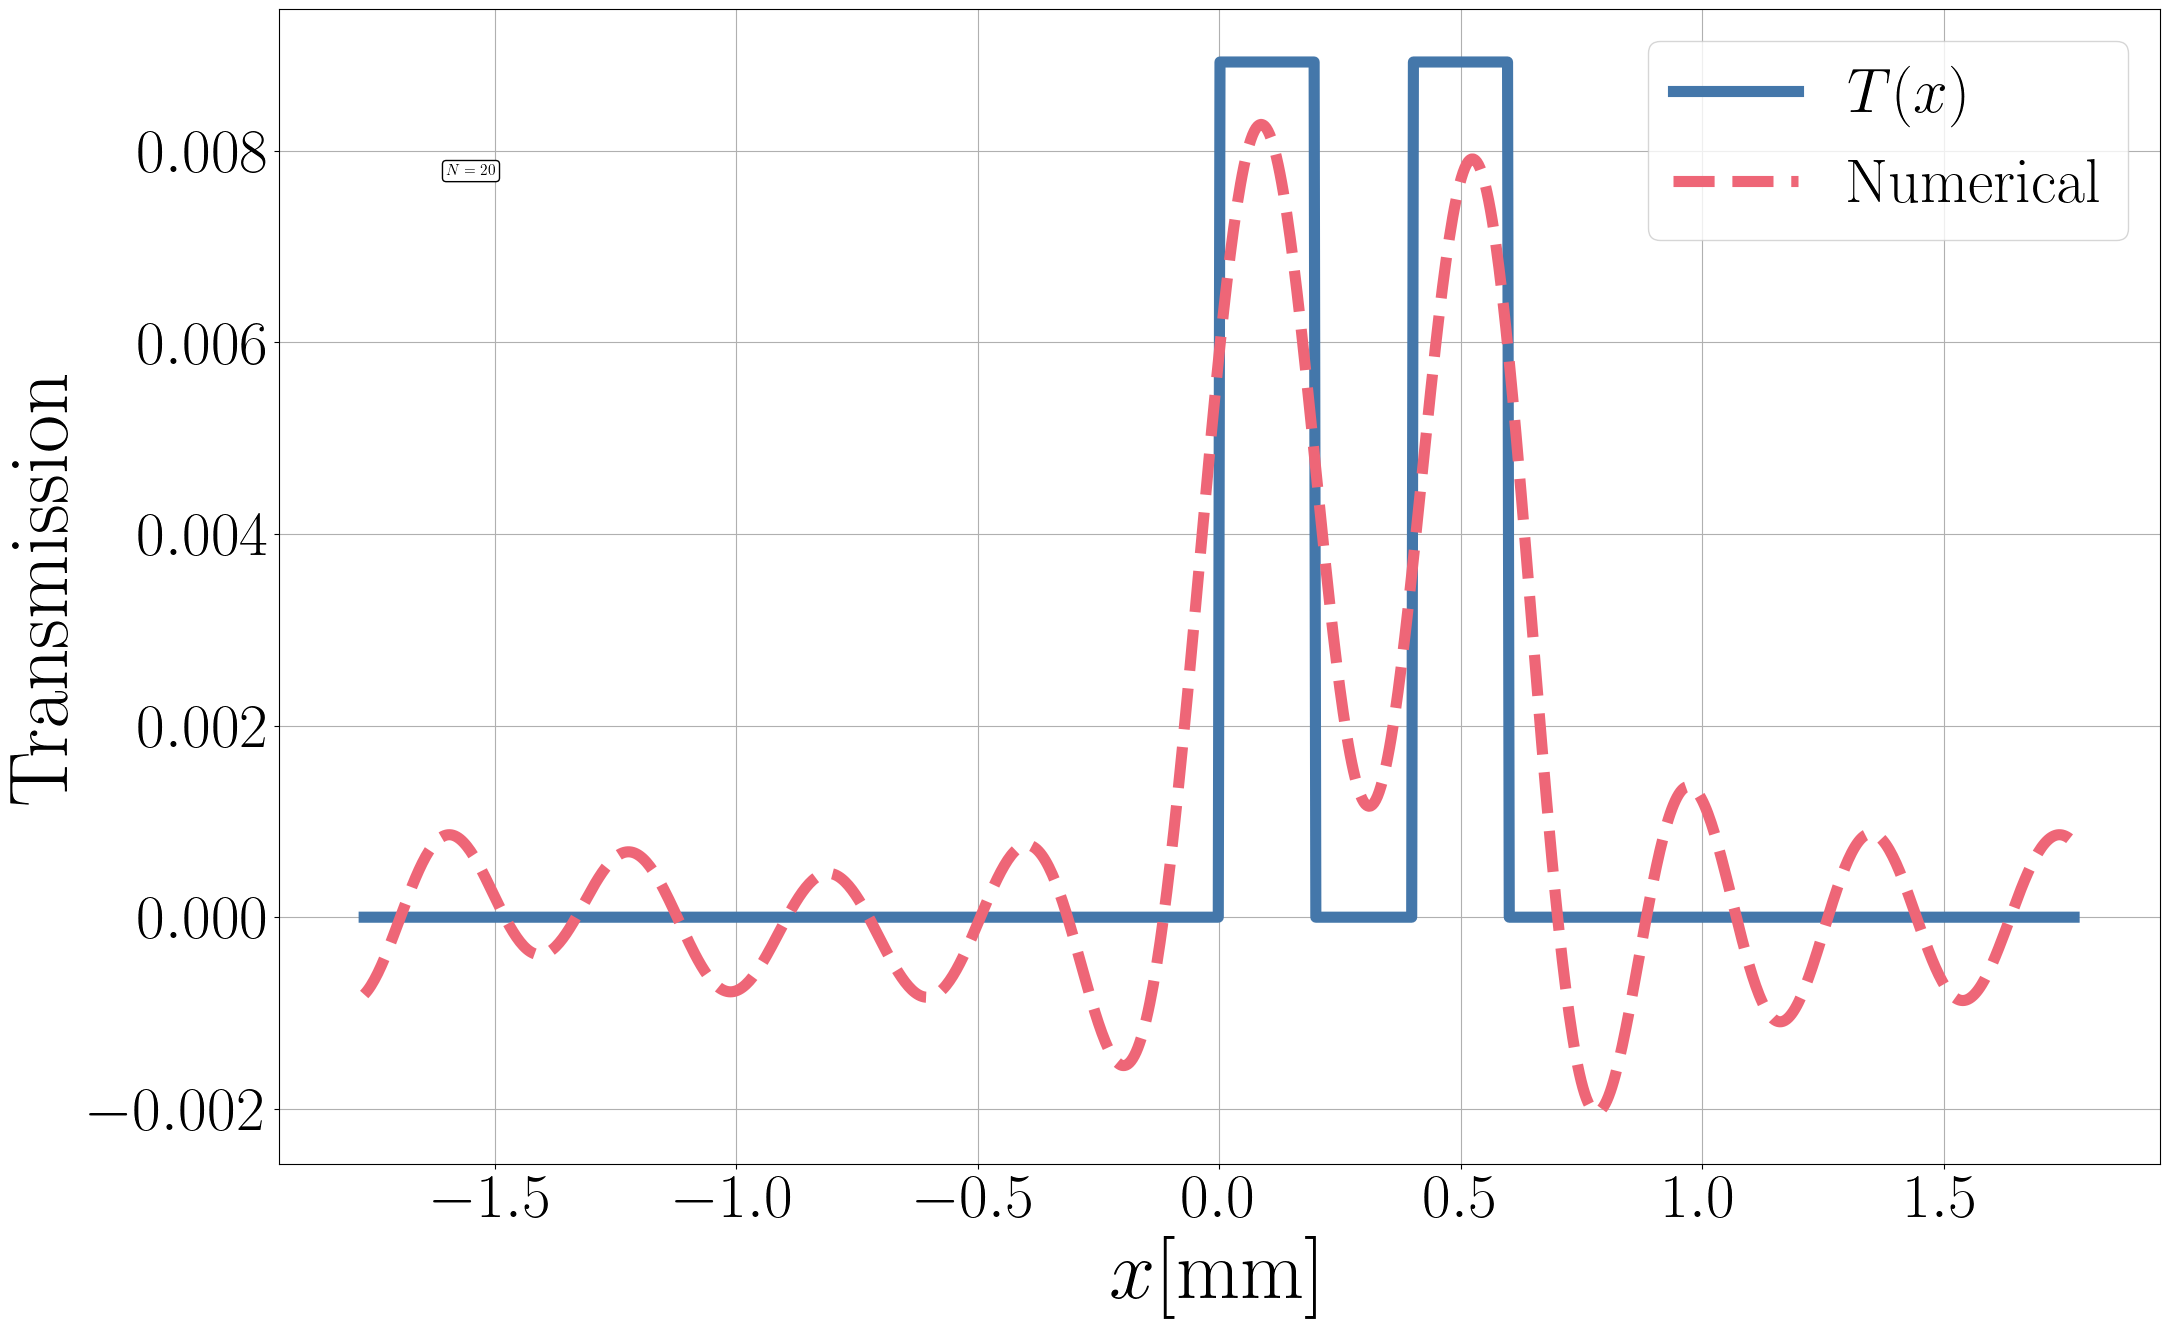

In [33]:
#Checking that the sine coefficients are zero
bn, In, xvals = np.empty(20), np.empty(20), np.empty(20)
for i in range(9):
    val = (res/(4*(i + 1)))
    indx = np.argmin(abs(xpos_finer - val))
    #plt.plot(abs(xpos_finer - val))
    #print('Diff: ', round(xpos_finer[indx]-val,3))
    xvals[i] = xpos_finer[indx]
    In[i] = simple_cos(xpos_finer, *nic_hc_fits[i])[indx]
    bn[i] = 2*simple_cos(xpos_finer, *nic_hc_fits[i])[indx] - 1
print('X pos: ', xvals)
print('I_n: ', In)
print('b_n: ', bn)

hh = 9
sine_recon_num = np.asarray([np.sum(np.array([bn[i-1]*np.sin(2*np.pi*i/res*x) \
                                for i in range(1,hh)]), axis=0) for x in xpos_finer])

#fig = plt.figure(figsize=(plot_width,plot_height))
#plt.plot(xpos_finer, sine_recon_num, label='sine', linewidth=5)
#plt.plot(xpos_finer, recon_num, label='cosine', linewidth=5)
#plt.plot(xpos_finer, sine_recon_num/np.sum(sine_recon_num + recon_num), label='normed sine', linewidth=5)
#plt.plot(xpos_finer, recon_num/np.sum(sine_recon_num + recon_num), label='normed cosine', linewidth=5)
#plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
#plt.ylabel('Transmission')
#plt.legend()
#plt.grid()
#plt.show()

fig = plt.figure(figsize=(plot_width,plot_height))
plt.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
#plt.plot(xpos_finer, recon_ana/np.sum(recon_ana), '-', linewidth=8, label='Analytical')
plt.plot(xpos_finer, (sine_recon_num + recon_num)/np.sum(sine_recon_num + recon_num), '--', label='Numerical', linewidth=8)
plt.xlabel('$x ' + r'[\unit{\milli \meter}]$')
plt.ylabel('Transmission')
plt.text(-1.6, 7.75e-3, r'$N = 20$', \
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
plt.legend()
plt.grid()
plt.show()


In [260]:
new_d, new_ld, new_ls = ap_dia, Ld, Ls
new_res = new_ls / (new_ld / new_d)
hhh = 7

print('R_geo (mm):', round(new_res,3))
print('R_aer (mm):', round(abs(2*np.pi/(cL*lambda0*MWP_str*(get_SS_focus(hhh,new_ls,new_res,lambda0,MWP_str,L) \
                                                     *((L4 + L3) - (L2 + L1)))))*1e3*new_ls,3))
print('R_aer (mm):', round(new_res/(hhh+1),3))
print('Current (A): ', round(get_SS_focus(hhh,new_ls,new_res,lambda0,MWP_str,L),3))

R_geo (mm): 3.333
R_aer (mm): 0.476
R_aer (mm): 0.417
Current (A):  8.632


I0= 0.0004
Norm= 11655918196.484377 

2.2064976616492345e-05


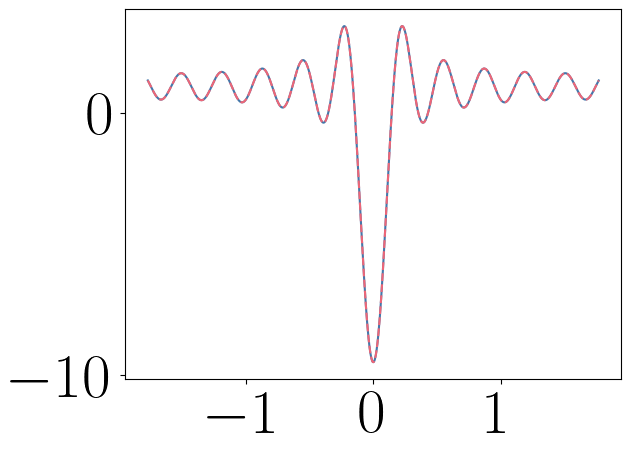

In [120]:
print('I0=', .24*res/2/(Ls*1e3)) #a0 =.24
print('Norm=', np.mean(nc_run[60:68:,60:68:])*(Ls*1e3)/2/(slit_x*1e-3), '\n')

print(np.mean(nc_run[63:65:,63:65:])/np.sum(nc_run)/res)

def c_term(x,N,R):
    return 1/2*(1 - (np.cos(2*np.pi*N/R*x) - np.cos(2*np.pi*(N+1)/R*x) + np.cos(2*np.pi/R*x) - 1)/(1 - np.cos(2*np.pi/R*x)))
def c_term_sum(x,N,R):
    return 1/2 - np.sum([np.cos(2*np.pi*i/R*x) for i in range(1,N+1)], axis=0)

temp = 10
fig = plt.plot(xpos_finer, c_term_sum(xpos_finer, temp, res), '-')
plt.plot(xpos_finer, c_term(xpos_finer, temp, res), '--')
ax = plt.gca()
plt.show()


2022-05-25 23:05:36,960 WARNING:MovieWriter ffmpeg unavailable; using Pillow instead.


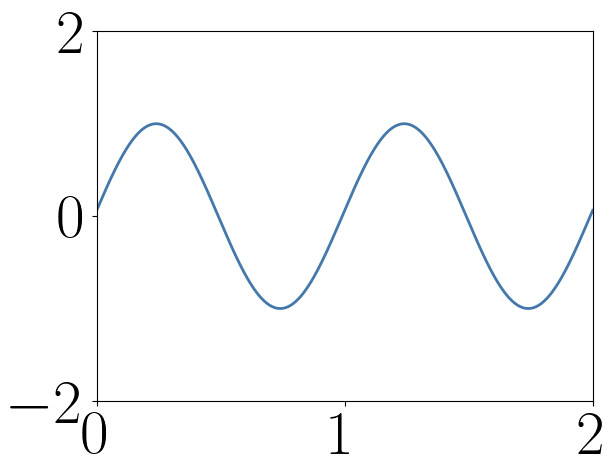

In [123]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.gif', fps=30)

plt.show()

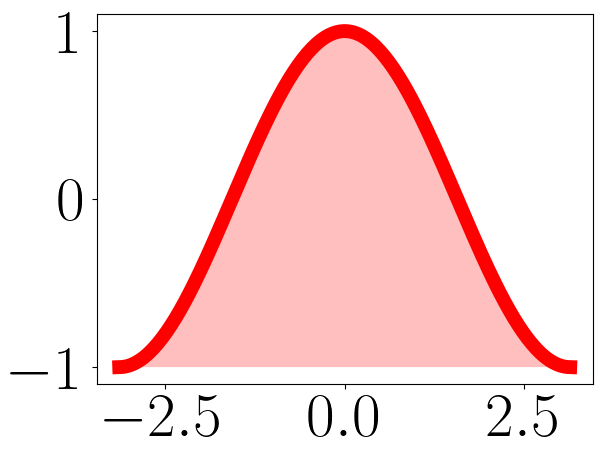

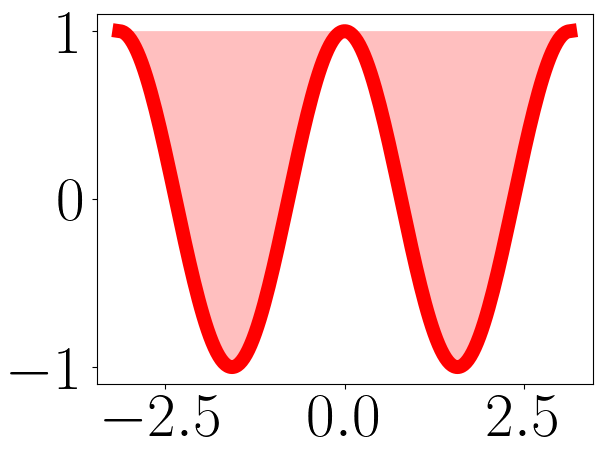

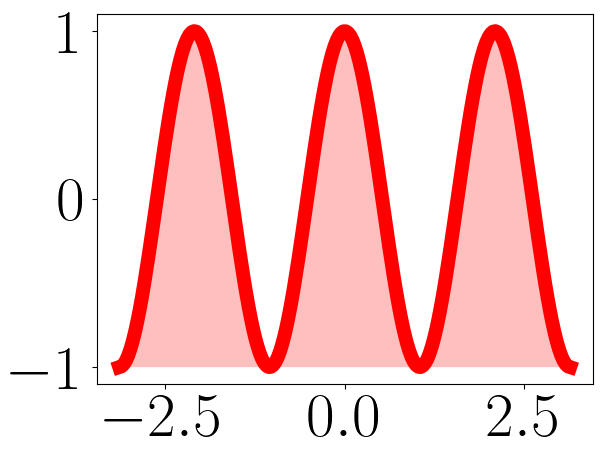

In [5]:
temp = np.linspace(-np.pi,np.pi,200)

plt.plot(temp, np.cos(temp), linewidth=10, color='red')
plt.fill(temp, np.cos(temp), linewidth=0, color='red', alpha=0.25)
plt.show()

plt.plot(temp, np.cos(2*temp), linewidth=10, color='red')
plt.fill(temp, np.cos(2*temp), linewidth=0, color='red', alpha=0.25)
plt.show()

plt.plot(temp, np.cos(3*temp), linewidth=10, color='red')
plt.fill(temp, np.cos(3*temp), linewidth=0, color='red', alpha=0.25)
plt.show()